# Performance Bencharmk: Accessing Datasets in the Jasmin Object Store

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

from performance_plots import plot_barplot, plot_lineplot
from performance_utils import calculate_speed_up

In [2]:
# Warning settings
warnings.filterwarnings("ignore")

# Seaborn settings
sns.set()
sns.set_style("white")
sns.set_context("notebook", font_scale=0.95)

# Matplotlib settings
plt.rcParams.update({"xtick.bottom": True, "ytick.left": True})

In [3]:
output_file_prefix = "performance_annual_mean_surface_layer"
save_fig = False
error_kwargs = {"capsize": 0.1, "errwidth": 1, "errorbar": "sd"}

## Annual Mean of the Surface Layer

In [4]:
# Open the csv file
df = pd.read_csv("benchmark_data/csv_files/performance_annual_mean_surface_layer.csv")
df.drop(df.filter(regex="Unname"), axis=1, inplace=True)
df.head()

,Replicate,Configuration,Walltime,Label,Dataset,Nodes,Number of cores
0,1,1:1:1,234.423494,multithreading,kerchunk-part-month-orig,1,1
1,2,1:1:1,245.996224,multithreading,kerchunk-part-month-orig,1,1
2,3,1:1:1,238.223454,multithreading,kerchunk-part-month-orig,1,1
3,4,1:1:1,230.204103,multithreading,kerchunk-part-month-orig,1,1
4,1,2:1:2,129.514922,multithreading,kerchunk-part-month-orig,1,2


### Walltime as a function of the number of cores

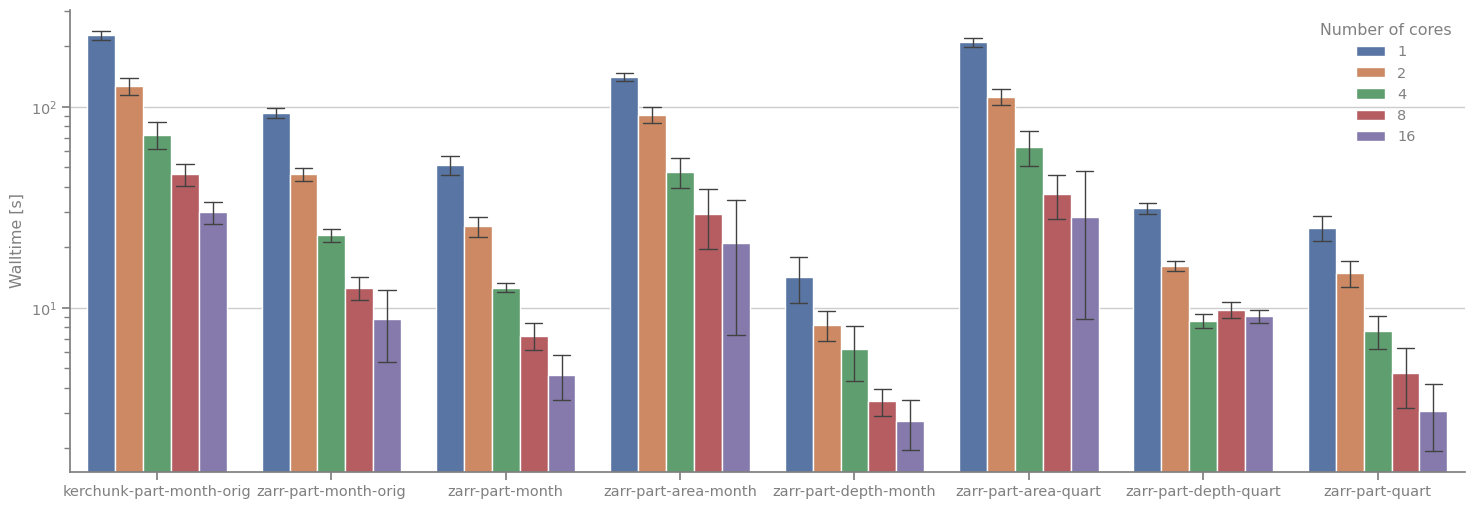

In [5]:
f, ax = plt.subplots(figsize=(18, 6))
ax = plot_barplot(ax, df, leg_title="Number of cores", error_kwargs=error_kwargs)
if save_fig:
    plt.savefig(
        f"{output_file_prefix}_walltime_vs_ncores.png",
        dpi=300,
        transparent=True,
        bbox_inches="tight",
    )
plt.show()

### Best performing parallel configuration: distributed or shared memory?

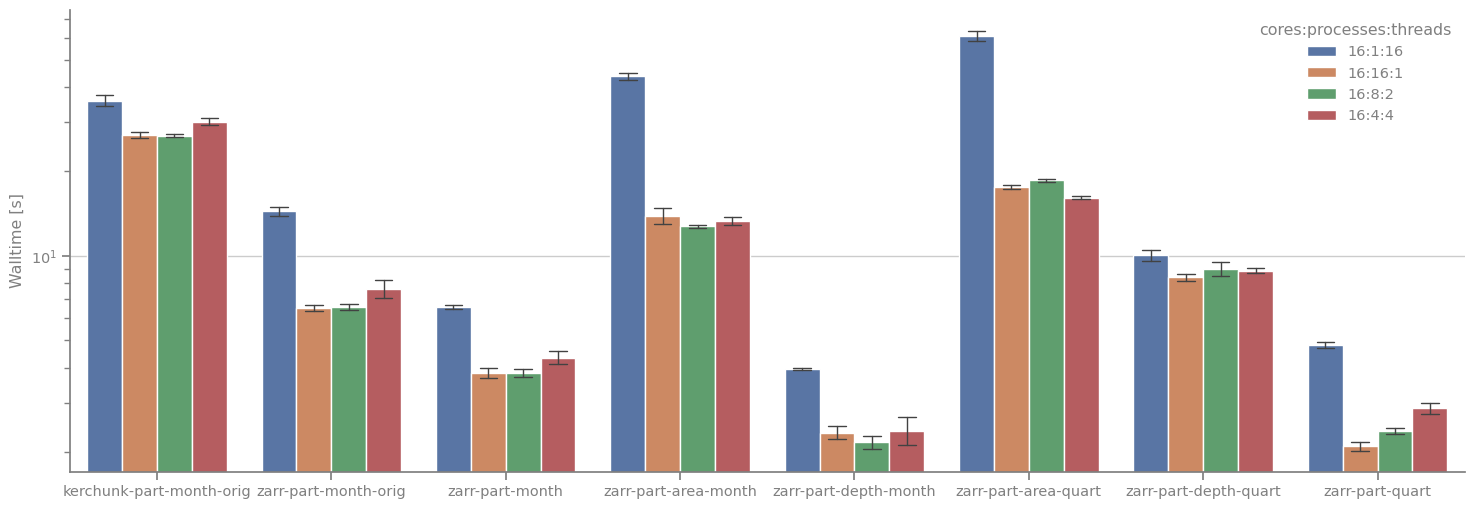

In [6]:
df_16 = df.loc[(df["Number of cores"] == 16)]
f, ax = plt.subplots(figsize=(18, 6))
ax = plot_barplot(
    ax,
    df_16,
    hue="Configuration",
    leg_title="cores:processes:threads",
    error_kwargs={"capsize": 0.1, "errwidth": 1, "errorbar": "sd"},
)
if save_fig:
    plt.savefig(
        f"{output_file_prefix}_parallel_configuration.png",
        dpi=300,
        transparent=True,
        bbox_inches="tight",
    )
plt.show()

### Parallel scaling performance

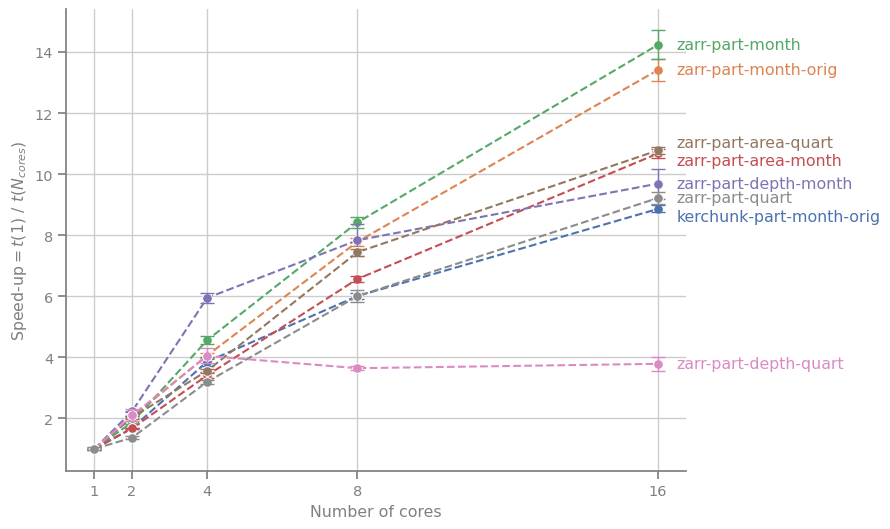

In [7]:
# Select best performing configuration
df_mixed_2 = df.loc[(df["Label"] == "mixed-2")]
df_mixed_2 = df_mixed_2.reset_index()

# Calculate speed-up
df_mixed_2 = calculate_speed_up(df_mixed_2)

# Plot
f, ax = plt.subplots(figsize=(8, 6))
error_kwargs = {
    "err_kws": {"lw": 1, "capsize": 5},
    "err_style": "bars",
    "errorbar": "sd",
}
plot_lineplot(
    ax,
    df_mixed_2,
    x="Number of cores",
    y="Speed-up",
    hue="Dataset",
    error_kwargs=error_kwargs,
)

# Extra costumisation
ax.set_xticks([1, 2, 4, 8, 16])
ax.legend([], [], frameon=False)
datasets = df_mixed_2.drop_duplicates("Dataset")["Dataset"].tolist()
means = [
    df_mixed_2.loc[
        (df_mixed_2["Number of cores"] == 16) & (df_mixed_2["Dataset"] == dataset)
    ].mean()["Speed-up"]
    for dataset in datasets
]
for value, dataset, color in zip(means, datasets, sns.color_palette("deep")):
    if dataset == "zarr-part-area-quart":
        value = value + 0.25
    elif dataset == "zarr-part-area-month":
        value = value - 0.25
    elif dataset == "kerchunk-part-month-orig":
        value = value - 0.25
    ax.text(x=16 + 0.5, y=value, s=dataset, va="center", color=color)

plt.show()

### Scaling to multiple nodes

In [8]:
# Open the csv file
df_multiple = pd.read_csv(
    "benchmark_data/csv_files/performance_annual_mean_surface_layer_multiple_nodes.csv"
)
df_multiple.drop(df_multiple.filter(regex="Unname"), axis=1, inplace=True)
df_multiple.head()

,index,Replicate,Configuration,Walltime,Label,Dataset,Nodes,Number of cores
0,0,1.0,1:1:1,234.423494,multithreading,kerchunk-part-month-orig,1.0,1.0
1,1,2.0,1:1:1,245.996224,multithreading,kerchunk-part-month-orig,1.0,1.0
2,2,3.0,1:1:1,238.223454,multithreading,kerchunk-part-month-orig,1.0,1.0
3,3,4.0,1:1:1,230.204103,multithreading,kerchunk-part-month-orig,1.0,1.0
4,4,1.0,2:1:2,129.514922,multithreading,kerchunk-part-month-orig,1.0,2.0


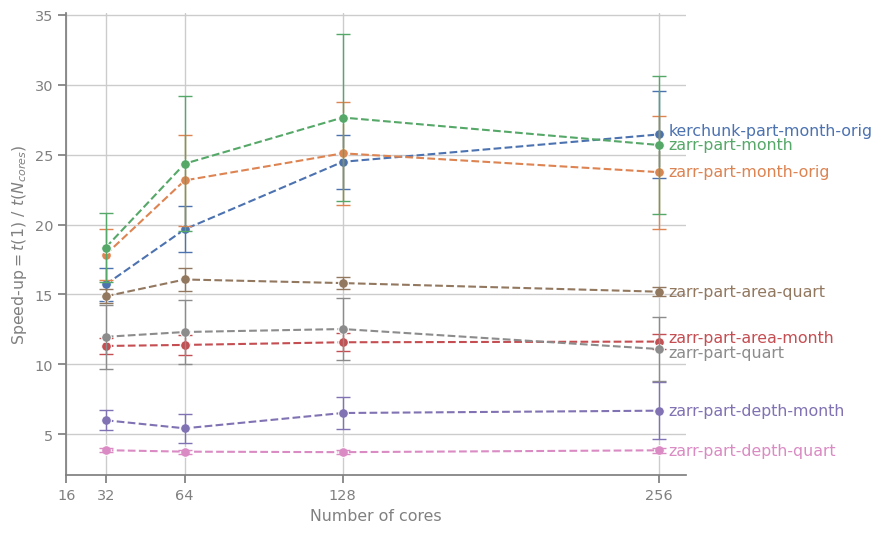

In [9]:
# Select "mixed-2" parallel config
df_multiple_mix = df_multiple.loc[(df_multiple["Label"] == "mixed-2")]
df_multiple_mix.reset_index(inplace=True)

# Calculate speed-up
df_multiple_mix = calculate_speed_up(df_multiple_mix)

# Drop data corresponding to 1, 2, 4 and 8 cores
to_drop = [1, 2, 4, 8, 16]
for n in to_drop:
    df_multiple_mix.drop(
        df_multiple_mix[df_multiple_mix["Number of cores"] == n].index, inplace=True
    )

# Plot
f, ax = plt.subplots(figsize=(8, 6))
error_kwargs = {
    "err_kws": {"lw": 1, "capsize": 5},
    "err_style": "bars",
    "errorbar": "sd",
}
plot_lineplot(
    ax,
    df_multiple_mix,
    x="Number of cores",
    y="Speed-up",
    hue="Dataset",
    error_kwargs=error_kwargs,
)

# Extra costumisation
ax.set_xticks([2**n for n in range(4, 9)])
ax.legend([], [], frameon=False)


datasets = df.drop_duplicates("Dataset")["Dataset"].tolist()
means = [
    df_multiple_mix.query(f"`Number of cores` == 256 & Dataset == '{dataset}'").mean()[
        "Speed-up"
    ]
    for dataset in datasets
]

for value, dataset, color in zip(means, datasets, sns.color_palette("deep")):
    if dataset == "zarr-part-quart":
        value = value - 0.3
    elif dataset == "zarr-part-area-month":
        value = value + 0.3
    elif dataset == "kerchunk-part-month-orig":
        value = value + 0.3
    ax.text(x=256 + 4, y=value, s=dataset, va="center", color=color)

if save_fig:
    plt.savefig(
        f"{output_file_prefix}_multiple_nodes.png",
        dpi=600,
        transparent=True,
        bbox_inches="tight",
    )

plt.show()

### Accessing from NOC servers: Nike and Themis

In [10]:
# Open the csv file
df_nike = pd.read_csv(
    "benchmark_data/csv_files/performance_annual_mean_surface_layer_nike.csv"
)
df_themis = pd.read_csv(
    "benchmark_data/csv_files/performance_annual_mean_surface_layer_themis.csv"
)

# Add server column
df_nike["Server"] = "Nike"
df_themis["Server"] = "Themis"
df["Server"] = "Lotus"

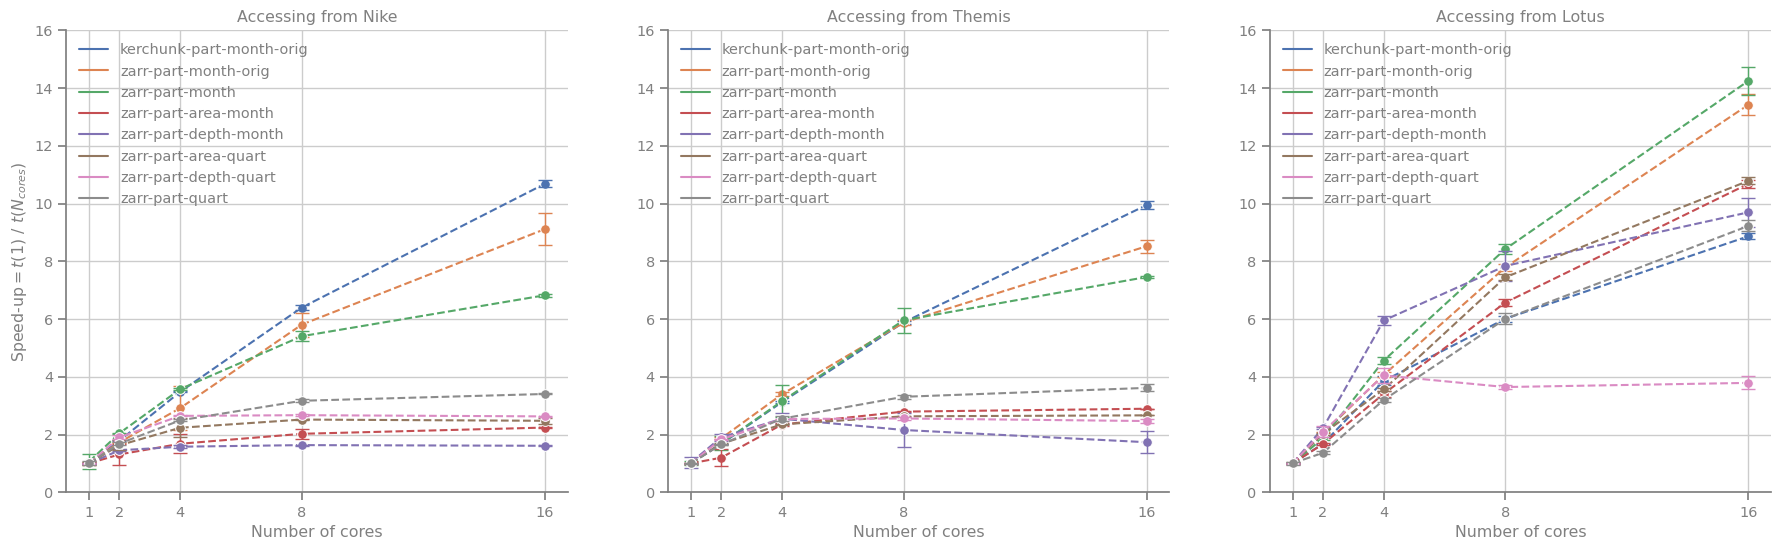

In [11]:
f, axes = plt.subplots(1, 3, figsize=(22, 6))
ax1, ax2, ax3 = axes

plt.subplots_adjust(wspace=0.2)
error_kwargs = {
    "err_kws": {"lw": 1, "capsize": 5},
    "err_style": "bars",
    "errorbar": "sd",
}


for dataframe, ax, server in zip(
    [df_nike, df_themis, df], [ax1, ax2, ax3], ["Nike", "Themis", "Lotus"]
):
    # Select mixed-2
    dataframe_mixed_2 = dataframe.loc[(dataframe["Label"] == "mixed-2")]
    dataframe_mixed_2 = dataframe_mixed_2.reset_index()

    # Calculate speed-up
    dataframe_mixed_2 = calculate_speed_up(dataframe_mixed_2)

    plot_lineplot(
        ax,
        dataframe_mixed_2,
        x="Number of cores",
        y="Speed-up",
        hue="Dataset",
        ylabel="",
        error_kwargs=error_kwargs,
    )
    ax.set_ylim([0, 16])
    ax.set_xticks([1, 2, 4, 8, 16])
    ax.set_title(f"Accessing from {server}", color="grey")


ax1.set_ylabel(r"Speed-up$=t(1)\ /\ t(N_{cores})$")

if save_fig:
    plt.savefig(
        f"{output_file_prefix}_noc_servers.png",
        dpi=600,
        transparent=True,
        bbox_inches="tight",
    )

plt.show()